In [63]:
!pip install tslearn -q

# Additional MSD analysis

Here I try to analyze two things:

- where are our 'easy', 'hard' and 'rare'?
- characteristic of images with high MSD at start and slow decrease (e.g. their class distribution)
- try clustering of MSD as time-series (msd/epochs) to obtain sensible groups bounds

In [41]:
from utils import plot_images, IndexedDataset

import random

import torch
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

from torchvision import datasets

SEED=42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED);

In [42]:
ds_train = IndexedDataset(datasets.CIFAR10(root='../data'))

In [43]:
msd_hist = torch.load('msd_hist.pt').numpy()
msd_means = np.mean(msd_hist[1:], axis=0)
msd_stds = msd_hist[1:].std(axis=0)

## 0. Are there any 'easy' examples? $\exists x$  s.t. MSD significantly drops after first epochs

In previous analysis what we did is ordered examples in dataset by $ \mu_{i} = \frac{1}{T}\sum_{t=0}^{T} MSD_t(x_i)$ - average MSD of point. This naturally allowed to select points with MSD that on average have MSD close to zero across epochs and ones with higher MSD on average **through all epochs** (the ones with slowly decreasing mean).

However, hypothesis is that there should exist examples that are supposed to be leanred fast, so called 'simple'. This would have stable representations after several epochs. In attempt to identify them we will try to analyze dynamics of slice of selected group points from first epochs.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


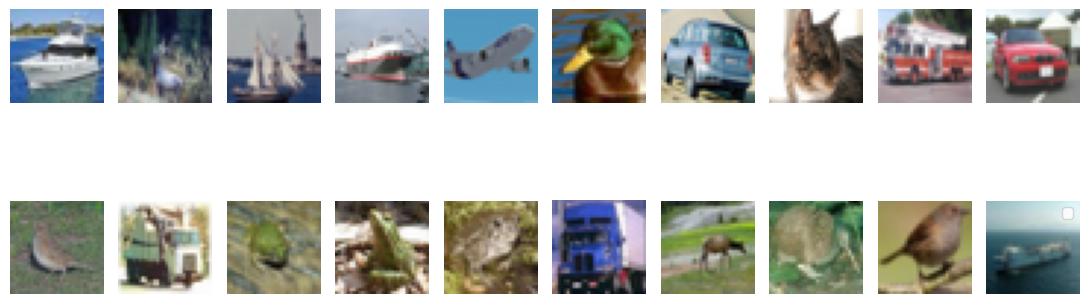

In [47]:
n_easy=50
M=3

msd_mean_early_slice = np.mean(msd_hist[1:M], axis=0)
sorted_early_idx = np.argsort(msd_mean_early_slice)
easy_idx_early = sorted_early_idx[-n_easy:]

imgs = [(ds_train[idx][1], ds_train[idx][2] for idx in easy_idx_early[:20]]
_, axs = plt.subplots(20 // 10, 10, figsize=(11, 5))
for idx, ax in enumerate(axs.flatten()):
    ax.imshow(imgs[idx][0], label=imgs[idx][1])
    ax.axis('off')

plt.legend()
plt.tight_layout()
plt.show()

It seems that these images with big MSD at first epochs indeed come out as ones with distinguishable features AND not confusing in terms of labels (not noisy labels). We can look at their dynamics and observe that their MSD decreases faster.

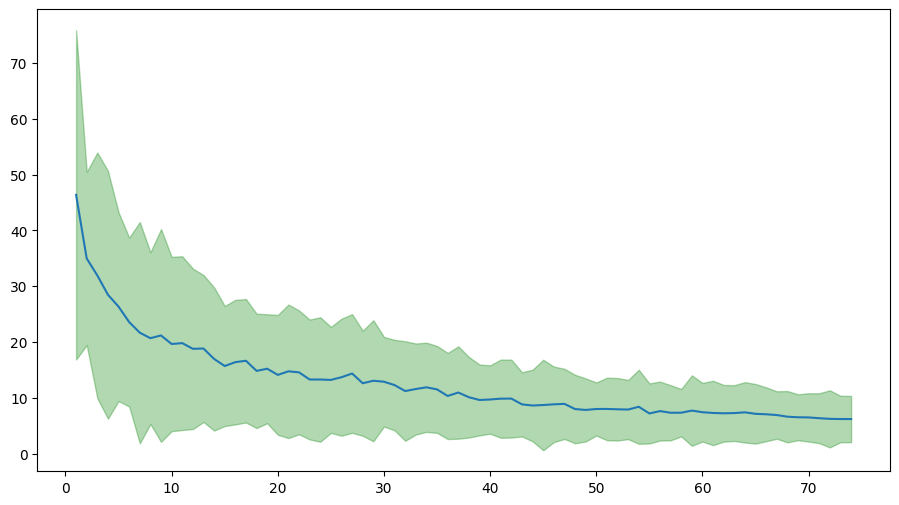

In [5]:
plt.figure(figsize=(11, 6))
msd_easy_hist = np.array(msd_hist[1:, easy_idx_early])
easy_mean = np.mean(msd_easy_hist, axis=1)
easy_std = np.std(msd_easy_hist, axis=1)
plt.plot(list(range(1, 75)), easy_mean, label='Mean Easy')
plt.fill_between(list(range(1, 75)), easy_mean - 1.96*easy_std, easy_mean + 1.96*easy_std, color='green', alpha=0.3, label='Easy CI=95%')
plt.show()

Lastly, let's try to find examples that have greatest discrepancy of MSD at start and end of training. This intiuitive metric measures the change in updates at start and end of training.

$$D(k)_i = \frac{1}{k}\sum_{j=1}^{k} MSD_j(x_i) - \frac{1}{k}\sum_{j=T-k+1}^{T} MSD_j(x_i)$$

In [6]:
def msd_discrepancy(msd_hist, k, t='diff'):
    first_k_mean = np.mean(msd_hist[1:k+1], axis=0)
    last_k_mean = np.mean(msd_hist[-k:], axis=0)
    if t == 'ratio':
        return first_k_mean / last_k_mean
    elif t == 'diff':
        return first_k_mean - last_k_mean

disr_scores = msd_discrepancy(msd_hist, k=5, t='diff')
sorted_disr_idx = np.argsort(disr_scores)

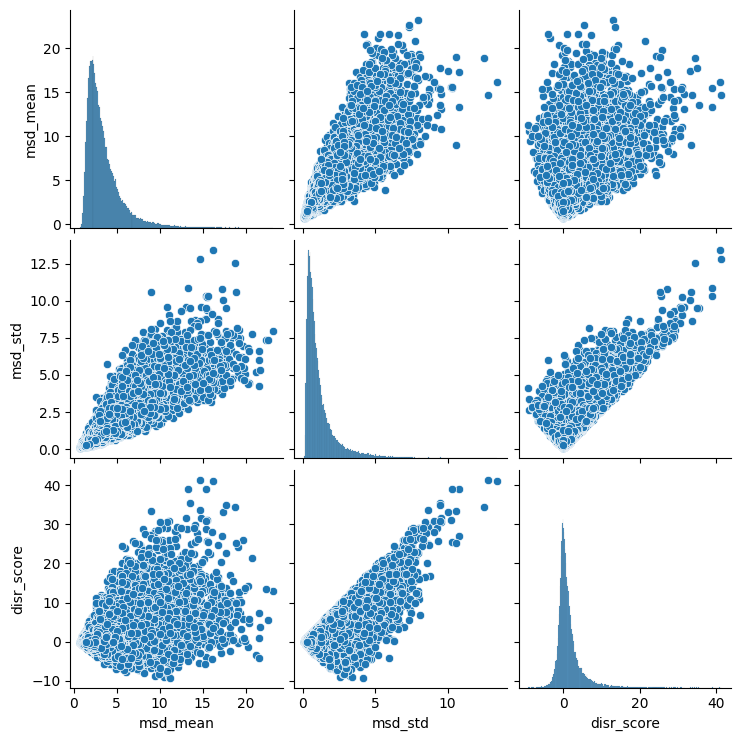

In [7]:
df = pd.DataFrame(data={'msd_mean': msd_means, 'msd_std': msd_stds, 'disr_score': disr_scores})
sns.pairplot(df, kind='scatter')
plt.show()

Let's look at images and observe trends with smallest/largest scores

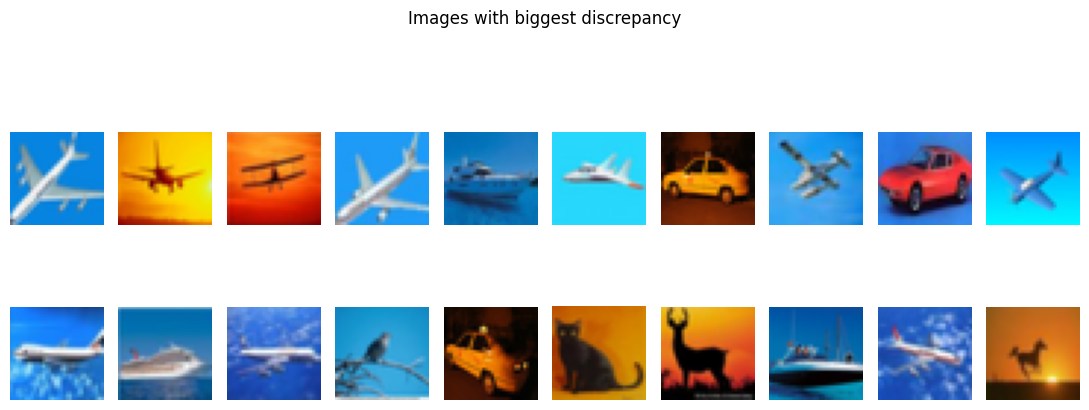

In [22]:
N=20
big_disr_idx = sorted_disr_idx[-N:][::-1]

imgs = [ds_train[idx][1] for idx in big_disr_idx[:20]]
_, axs = plt.subplots(20 // 10, 10, figsize=(11, 5))

for idx, ax in enumerate(axs.flatten()):
    ax.imshow(imgs[idx])
    ax.axis('off')

plt.suptitle("Images with biggest discrepancy")
plt.tight_layout()
plt.show()

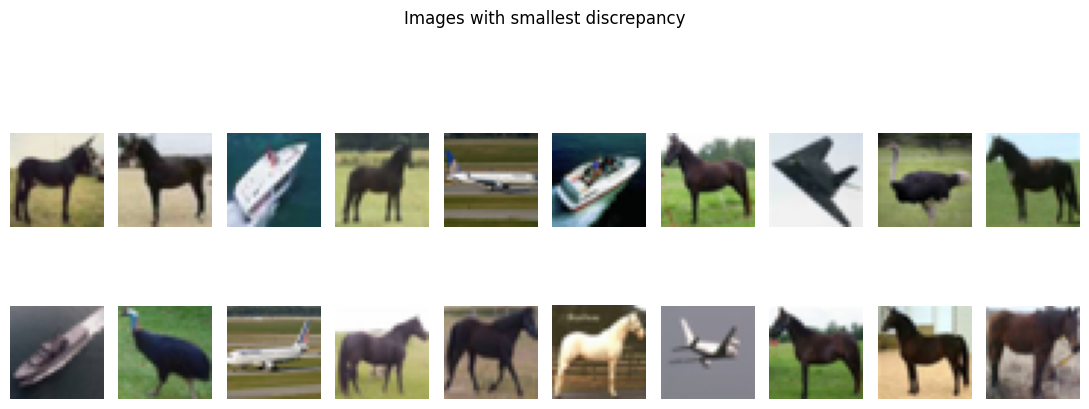

In [19]:
N=20
small_disr_idx = sorted_disr_idx[:N]

imgs = [ds_train[idx][1] for idx in small_disr_idx[:20]]
_, axs = plt.subplots(20 // 10, 10, figsize=(11, 5))
for idx, ax in enumerate(axs.flatten()):
    ax.imshow(imgs[idx])
    ax.axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle("Images with smallest discrepancy")
plt.tight_layout()
plt.show()

This metric is promissing, we can also try to induce smth similar through running average processing of MSD, which would also include information about speed of change of the metric

In [30]:
def run_avg_proc(msd_hist, w_size=3):
    res = np.zeros((msd_hist.shape[0] - 3, msd_hist.shape[1]))
    for idx in range(msd_hist.shape[1]):
        res[:, idx] = np.convolve(msd_hist[1:, idx], np.ones(w_size)/w_size, mode='valid')
    return res

msd_run_avg = run_avg_proc(msd_hist)

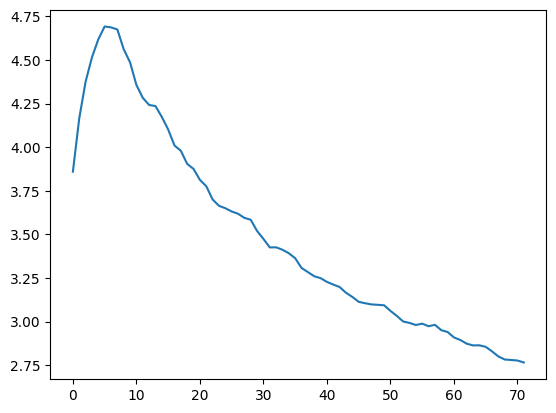

In [31]:
plt.plot(msd_run_avg.mean(axis=1))
plt.show()

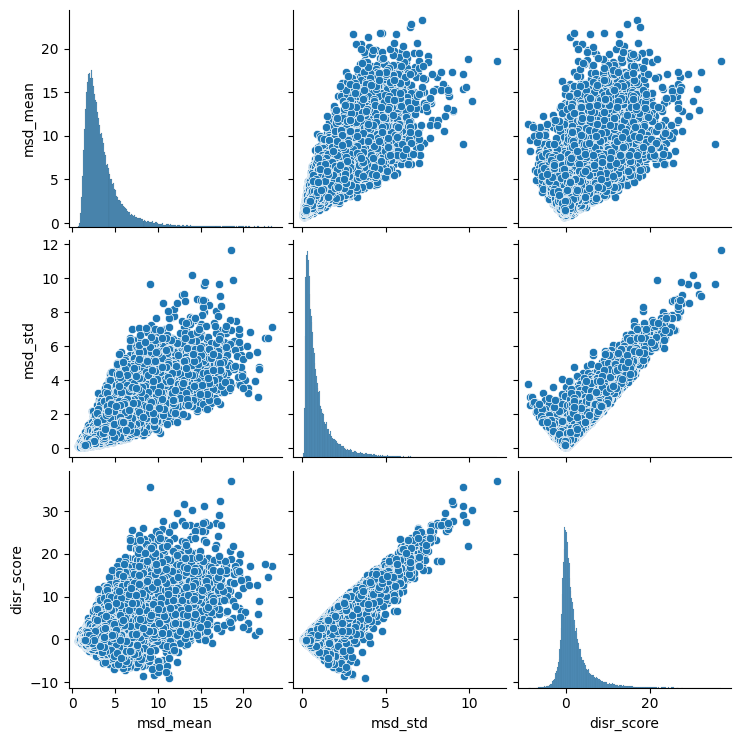

In [33]:
# mean and std of each sample msd
msd_ra_means = msd_run_avg.mean(axis=0)
msd_ra_stds = msd_run_avg.std(axis=0)
msd_ra_disr = msd_discrepancy(msd_run_avg, k=5, t='diff')

df_ra = pd.DataFrame(data={'msd_mean': msd_ra_means, 'msd_std': msd_ra_stds, 'disr_score': disr_scores})
sns.pairplot(df_ra, kind='scatter')
plt.show()

In [36]:
n=1000
msd_mean_big_idx = np.argsort(msd_means)[-n:][::-1]
msd_mean_small_idx = np.argsort(msd_means)[:n]

msd_big_labels = [ds_train[idx][2] for idx in msd_mean_big_idx]
msd_small_labels = [ds_train[idx][2] for idx in msd_mean_small_idx]

Let's look at distribution of clases in samples seleceted by msd mean

Num of 0 class: 551
Num of 1 class: 12
Num of 2 class: 73
Num of 3 class: 6
Num of 4 class: 33
Num of 5 class: 1
Num of 6 class: 50
Num of 7 class: 8
Num of 8 class: 265
Num of 9 class: 1


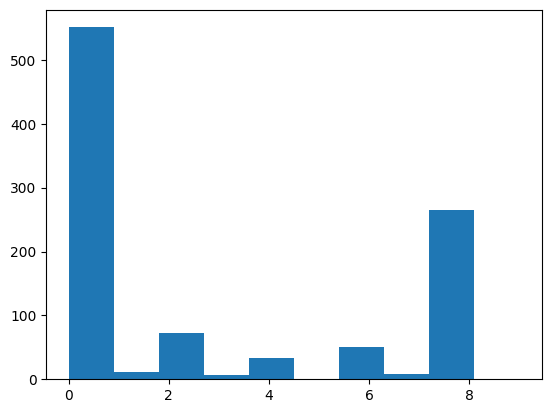

In [37]:
def plot_hist_of_labels(labels):
    _, cnts = np.unique(labels, return_counts=True)
    
    for idx, cnt in enumerate(cnts):
        print(f"Num of {idx} class: {cnt}")
    plt.hist(labels)
    plt.show()

plot_hist_of_labels(msd_big_labels)

Num of 0 class: 44
Num of 1 class: 68
Num of 2 class: 145
Num of 3 class: 269
Num of 4 class: 66
Num of 5 class: 150
Num of 6 class: 58
Num of 7 class: 63
Num of 8 class: 30
Num of 9 class: 107


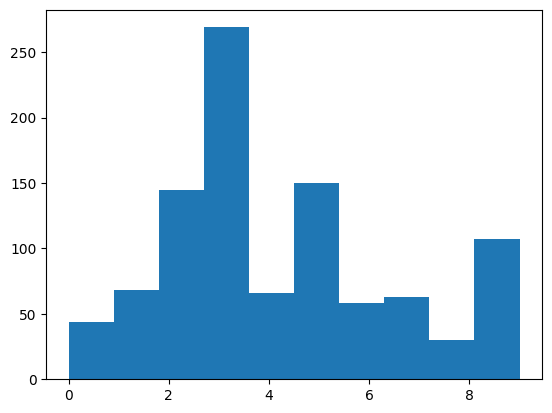

In [38]:
plot_hist_of_labels(msd_small_labels)

Num of 0 class: 151
Num of 1 class: 123
Num of 2 class: 88
Num of 3 class: 5
Num of 4 class: 53
Num of 5 class: 29
Num of 6 class: 45
Num of 7 class: 428
Num of 8 class: 60
Num of 9 class: 18


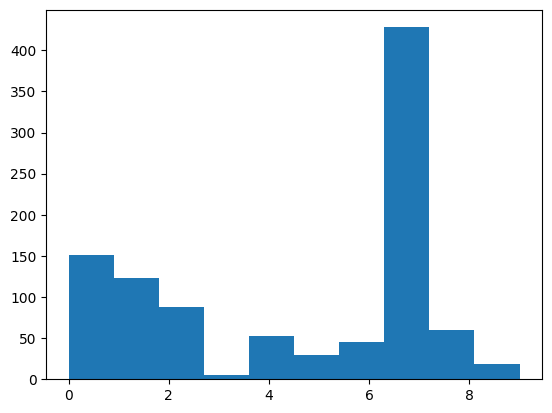

In [39]:
plot_hist_of_labels([ds_train[idx][2] for idx in sorted_disr_idx[:n]])

Num of 0 class: 380
Num of 1 class: 129
Num of 2 class: 57
Num of 3 class: 44
Num of 4 class: 31
Num of 5 class: 22
Num of 6 class: 56
Num of 7 class: 11
Num of 8 class: 220
Num of 9 class: 50


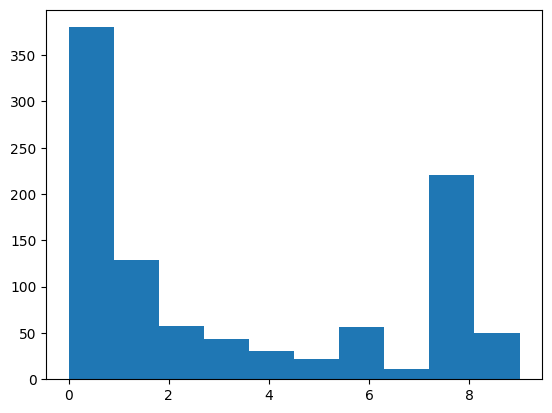

In [40]:
plot_hist_of_labels([ds_train[idx][2] for idx in sorted_disr_idx[-n:]])

## 3. Clustering of MSD as time-series data

https://tslearn.readthedocs.io/en/stable/index.html

In [81]:
X = msd_hist.T # examples x features
X.shape

(50000, 75)

In [ ]:
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

from sklearn.utils import resample
from tqdm import tqdm

def estimate_num_of_clusters(X, n_min, n_max, n_bootstraps=10):    
    si_scores = []

    n_range = list(range(n_min, n_max+1))
    for n_clusters in tqdm(n_range):
        scores = []
        for _ in range(n_bootstraps):
            X_sample = resample(X, n_samples=1000, replace=True)
            y_pred = TimeSeriesKMeans(n_clusters=n_clusters, random_state=SEED, tol=1e-4).fit_predict(X_sample)
            
            scores.append(silhouette_score(X_sample, y_pred))
            
        si_scores.append(
            np.mean(scores),
        )

    return n_range[np.argmax(n_clusters)]

scaler = TimeSeriesScalerMeanVariance()
X_train = scaler.fit_transform(X)
best_n_clustesrs = estimate_num_of_clusters(X_train, n_min=2, n_max=10, n_bootstraps=5)


In [90]:
print(f"Bootstrap estimate of number of clusters: {best_n_clustesrs}")

Bootstrap estimate of number of clusters: 2


In [91]:
km = TimeSeriesKMeans(n_clusters=best_n_clustesrs, random_state=SEED, tol=1e-4)
y_pred = km.fit_predict(X_train)

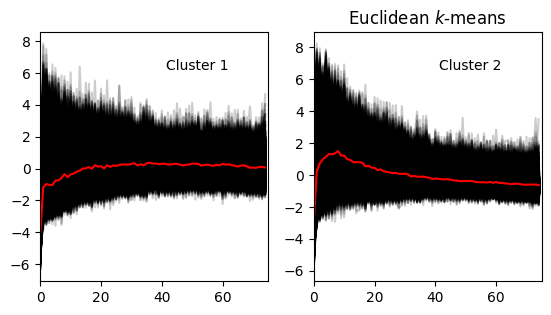

In [92]:
plt.figure(figsize=(10, 11))
for yi in range(best_n_clustesrs):
    plt.subplot(3, 3, yi + 1)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, 75)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

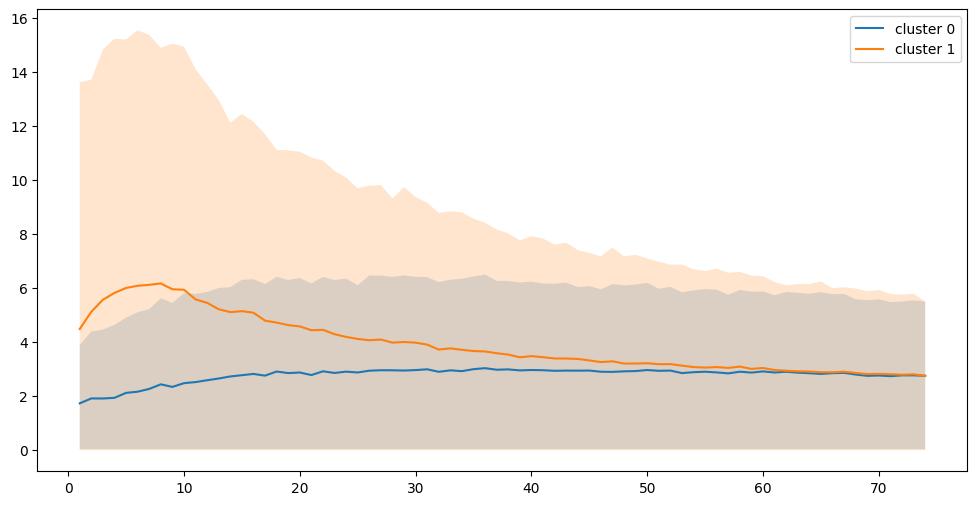

In [113]:
# plot in original scale and display with std 
plt.figure(figsize=(12, 6))
for yi in range(2):
    xx = X[y_pred == yi]
    cluster_std = np.std(xx[:, 1:], axis=0)

    cluster_mean = np.mean(xx[:, 1:], axis=0) 
    plt.plot(list(range(1, 75)), cluster_mean, label=f"cluster {yi}")
    plt.fill_between(list(range(1, 75)), np.max(cluster_mean - 1.96*cluster_std, 0), cluster_mean + 1.96*cluster_std, alpha=0.2)

plt.legend()
plt.show()

Let's add this labels to features above and observe scatter plots

In [54]:
df = pd.read_csv('msd_statistics.csv')
df.groupby('cluster').count()

,Unnamed: 0,msd_mean,msd_std,disr_score
cluster,,,,
0,18542,18542,18542,18542
1,31458,31458,31458,31458


In [114]:
df['cluster'] = y_pred
df.head()

,msd_mean,msd_std,disr_score,cluster
0,3.279041,1.809704,4.590792,1
1,2.037585,0.434451,0.207256,1
2,4.009675,1.606036,2.567637,1
3,5.026190,1.767881,3.576884,1
4,4.029313,1.400813,2.431490,1


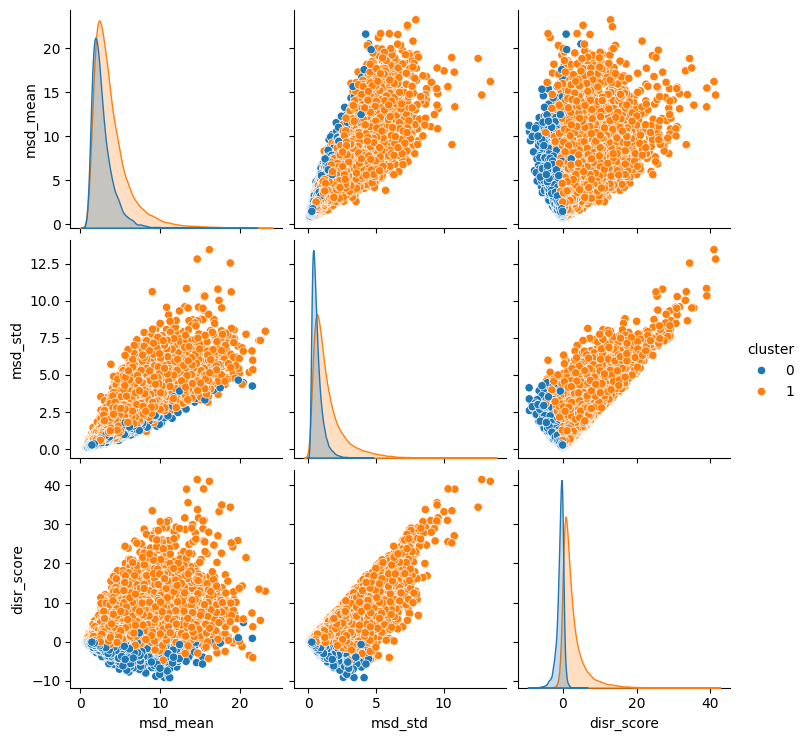

In [115]:
sns.pairplot(df, kind='scatter', hue='cluster')
plt.show()